<h1>SC3000 Assignment 1
<h3>Tutorial Group: A51
<h3>Group Name: Radioactive
<h3>Group Members:

*   Bernice Koh Jun Yan
> Contributions: Implemented Deep Q Learning model, Refined main code
*   Vedansh Bansal
> Contributions: Implemented Policy Guided Learning model, Refined main code
*   Lohia Vardhan
> Contributions: Implemented Policy Guided Learning model, Refined main code



# Our Solution for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [0.02794147 0.01996589 0.04220092 0.02469545]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.02834078 -0.17573506  0.04269482  0.3303889 ]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

<h1>Model: Deep Q Learning</h1>
For the Deep Q Learning model, we will be using Deep Reinforcement Learning for Keras, where we can find state-of-the-art deep reinforcement learning (RL) algorithms in Python

GitHub Link: https://github.com/keras-rl/keras-rl

<h2>Step 1: Setting up dependencies for our model

In [5]:
#install keras-rl library
!pip install keras-rl2

#install CartPole environment dependencies
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#import dependencies
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy

<h2>Step 2: Setting up the Deep Q-Learning model

In [11]:
#Defining number of available actions
nb_actions = env.action_space.n

# Create the Keras model
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary()) #checking the shape of the neural network layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# Define the Deep Q-Learning agent
policy = EpsGreedyQPolicy()
memory = SequentialMemory(limit=50000, window_length=1)
#Creating the Deep Q-lEarning agent
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(optimizer=Adam(lr=1e-3), metrics=['mae'])


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<h2>Step 3: Training the model

We experiemented with different quantities of training data, results can be found in Task 2.

In [13]:
TRAINING_QTY= 50000
dqn.fit(env, nb_steps=TRAINING_QTY, verbose=2, visualize=False)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` 

Training for 50000 steps ...
     9/50000: episode: 1, duration: 0.069s, episode steps:   9, steps per second: 131, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 13 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 15 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 16 + 1) instead
  batch_idxs

    17/50000: episode: 2, duration: 0.502s, episode steps:   8, steps per second:  16, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.543074, mae: 0.566137, mean_q: 0.480936
    28/50000: episode: 3, duration: 0.075s, episode steps:  11, steps per second: 146, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.909 [0.000, 1.000],  loss: 0.481238, mae: 0.523054, mean_q: 0.539781
    37/50000: episode: 4, duration: 0.070s, episode steps:   9, steps per second: 128, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.437651, mae: 0.483768, mean_q: 0.612919
    46/50000: episode: 5, duration: 0.071s, episode steps:   9, steps per second: 127, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.389574, mae: 0.453987, mean_q: 0.726967
    56/50000: episode: 6, duration: 0.063s, episode steps:  10, step

<h2>Step 4: Demonstrating the correctness of the implementation by sampling a random state from the cart pole environment

In [14]:
observation = env.reset() #resetting the environment
action = dqn.forward(observation) #inputting to the agent and agent outputs a chosen action
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.0165354   0.04361364  0.014025   -0.03209947]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, we used the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round.

In [15]:

er=[] #initialise episode results list

for x in range(100): #playing for 100 episodes
  observation = env.reset() #resetting the environment
  cumulative_reward = 0
  done = False
  while not done:
      observation, reward, done, info = env.step(dqn.forward(observation))
      cumulative_reward += reward
  er.append(cumulative_reward) #adding results to er list

episode_results= np.array(er) #convert list to numpy list

In [16]:
episode_results

array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500.])

<h2>Graphing the cumulative reward against all episodes

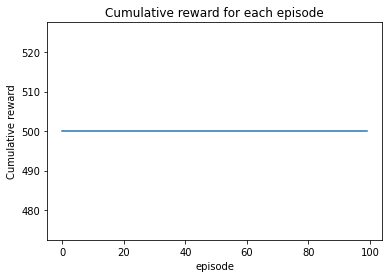

In [17]:
#plotting the cumulative reward against all episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

<h2>Printing the average reward over the 100 episodes.

In [18]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


<h1>Observations with various quantities of training data


*   10000 training data: Average= 72.86, Agent not good enough
*   20000 training data: Average= 137.14, Agent not good enough
* 30000 training data: Average= 412.7, Agent good enough
* 40000 training data: Average= 418.93, Agent good enough
* 50000 training data: Average= 500.00, Agent good enough





## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [19]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #action decided by the agent
    action = dqn.forward(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()

# Other Models that we tried but didn't work

## Policy Guided Learning




In [1]:
def reinforce(reset):
  action_result = []
  import torch

  gamma = 0.99
  lr = 0.001
  goal_score = 200
  log_interval = 10
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  import random
  from collections import namedtuple, deque

  Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

  class Memory(object):
      def __init__(self):
          self.memory = deque()

      def push(self, state, next_state, action, reward, mask):
          self.memory.append(Transition(state, next_state, action, reward, mask))

      def sample(self):
          memory = self.memory
          return Transition(*zip(*memory)) 

      def __len__(self):
          return len(self.memory)
  ##### 3
  import torch
  import torch.nn as nn
  import torch.nn.functional as F
  import numpy as np

  class QNet(nn.Module):
      def __init__(self, num_inputs, num_outputs):
          super(QNet, self).__init__()
          self.num_inputs = num_inputs
          self.num_outputs = num_outputs

          self.fc_1 = nn.Linear(num_inputs, 128)
          self.fc_2 = nn.Linear(128, num_outputs)

          for m in self.modules():
              if isinstance(m, nn.Linear):
                  nn.init.xavier_uniform(m.weight)

      def forward(self, input):
          x = F.relu(self.fc_1(input))
          policy = F.softmax(self.fc_2(x))
          return policy

      @classmethod
      def train_model(cls, net, transitions, optimizer):
          states, actions, rewards, masks = transitions.state, transitions.action, transitions.reward, transitions.mask

          states = torch.stack(states)
          actions = torch.stack(actions)
          rewards = torch.Tensor(rewards)
          masks = torch.Tensor(masks)

          returns = torch.zeros_like(rewards)

          running_return = 0
          for t in reversed(range(len(rewards))):
              running_return = rewards[t] + gamma * running_return * masks[t]
              returns[t] = running_return
          
          policies = net(states)
          policies = policies.view(-1, net.num_outputs)

          log_policies = (torch.log(policies) * actions.detach()).sum(dim=1)

          loss = (-log_policies * returns).sum()
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          return loss

      def get_action(self, input):
          policy = self.forward(input)
          policy = policy[0].data.numpy()

          action = np.random.choice(self.num_outputs, 1, p=policy)[0]
          return action

  import os
  import sys
  import gym
  import random
  import numpy as np

  import torch
  import torch.optim as optim
  import torch.nn.functional as F
  from tensorboardX import SummaryWriter


  env.seed(500)
  torch.manual_seed(500)
  num_inputs = env.observation_space.shape[0]
  num_actions = env.action_space.n
  print('state size:', num_inputs)
  print('action size:', num_actions)

  net = QNet(num_inputs, num_actions)

  optimizer = optim.Adam(net.parameters(), lr=lr)
  writer = SummaryWriter('logs')

  net.to(device)
  net.train()
  running_score = 0
  steps = 0
  loss = 0

  for e in range(1000):
      done = False
      memory = Memory()

      score = 0
      state = env.reset()
      state = torch.Tensor(state).to(device)
      state = state.unsqueeze(0)

      while not done:
          steps += 1

          action = net.get_action(state)
          action_result.append(action)
          next_state, reward, done, _ = env.step(action)

          next_state = torch.Tensor(next_state)
          next_state = next_state.unsqueeze(0)

          mask = 0 if done else 1
          reward = reward if not done or score == 499 else -1

          action_one_hot = torch.zeros(2)
          action_one_hot[action] = 1
          memory.push(state, next_state, action_one_hot, reward, mask)
  
          score += reward
          state = next_state

      loss = QNet.train_model(net, memory.sample(), optimizer)
          

      score = score if score == 500.0 else score + 1
      running_score = 0.99 * running_score + 0.01 * score
      if e % log_interval == 0:
          print('{} episode | score: {:.2f}'.format(
              e, running_score))
          writer.add_scalar('log/score', float(running_score), e)
          writer.add_scalar('log/loss', float(loss), e)

      if running_score > goal_score:
          break
  return action_result



<h2>Testing our model

In [4]:
env = gym.make("CartPole-v1")
!pip install tensorboardX > /dev/null 2>&1
observation = env.reset()
action = reinforce(observation)
print("Observation:", observation)
print("Chosen action:", action)

/usr/local/lib/python3.9/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
<ipython-input-1-e259927ff1b7>:46: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


state size: 4
action size: 2


<ipython-input-1-e259927ff1b7>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy = F.softmax(self.fc_2(x))


0 episode | score: 0.43
10 episode | score: 2.58
20 episode | score: 4.32
30 episode | score: 6.40
40 episode | score: 8.35
50 episode | score: 10.10
60 episode | score: 11.89
70 episode | score: 14.21
80 episode | score: 16.39
90 episode | score: 18.97
100 episode | score: 21.55
110 episode | score: 24.72
120 episode | score: 25.29
130 episode | score: 26.70
140 episode | score: 28.82
150 episode | score: 31.28
160 episode | score: 32.08
170 episode | score: 33.59
180 episode | score: 34.74
190 episode | score: 35.55
200 episode | score: 37.16
210 episode | score: 37.75
220 episode | score: 37.55
230 episode | score: 40.03
240 episode | score: 42.45
250 episode | score: 43.69
260 episode | score: 43.64
270 episode | score: 43.60
280 episode | score: 43.89
290 episode | score: 45.25
300 episode | score: 45.60
310 episode | score: 46.83
320 episode | score: 46.91
330 episode | score: 47.45
340 episode | score: 49.16
350 episode | score: 48.50
360 episode | score: 49.86
370 episode | sco

We decided not to use this model as the scores didn't meet the average score required.